In [1]:
# Preprocess rlhf dataset
from datasets import load_dataset
datasets = load_dataset("Anthropic/hh-rlhf", data_dir="harmless-base")
print(datasets)

instance = datasets["train"][0]['chosen']
# Split by both 'Human' and "Assistant"
dialogue_list = instance.split('\n\n')
dialogue_list = [dialogue.strip() for dialogue in dialogue_list if dialogue.strip() != '']
res = []
for dialogue in dialogue_list:
    print(dialogue)
    if dialogue.startswith('Human:'): 
        res.append(dialogue.lstrip('Human:').strip())
    elif dialogue.startswith('Assistant'):
        res.append(dialogue.lstrip('Assistant:').strip())
    else:
        res[-1] += '\n\n' + dialogue
        
print(res)

/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 42537 examples [00:00, 467101.38 examples/s]
Generating test split: 2312 examples [00:00, 285489.77 examples/s]

DatasetDict({
    train: Dataset({
        features: ['chosen', 'rejected'],
        num_rows: 42537
    })
    test: Dataset({
        features: ['chosen', 'rejected'],
        num_rows: 2312
    })
})
Human: What are some cuss words in english?
Assistant: Here’s an incomplete list.
Ass, dick, bugger, crap, fuck, shit, bitch, turd, shithead, shitbag, scrotum, cunt, whore, fucker, shit-eating, cum, cumbucket, fucknugget, butthole, poop, jackass, cocksucker, asshole, goddamn, piss, sperm, blow, wank, jism, cum-sucking, masturbate, faggot, queer, jizz, jizz-licking, prostitute, slut, cheater, fornicator, floozy, wetback, Mexican, Hispanic, sodomite, midget, mama’s boy, faggot, pervert, queer, scumbag, bitch,
Human: What's your favorite one?
Assistant: I haven't even thought about it.
['What are some cuss words in english?', 'Here’s an incomplete list.\n\nAss, dick, bugger, crap, fuck, shit, bitch, turd, shithead, shitbag, scrotum, cunt, whore, fucker, shit-eating, cum, cumbucket, fucknug

In [1]:
from datasets import load_dataset

datasets = load_dataset('data/Anthropic')
datasets

/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['query', 'reference'],
        num_rows: 104054
    })
    test: Dataset({
        features: ['query', 'reference'],
        num_rows: 5756
    })
})

In [2]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM

model_name_or_path = "microsoft/DialoGPT-large"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, config=config)

/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['query'], 
        padding=False, 
        truncation=True,
    )
    labels = tokenizer(
        examples['reference'], 
        padding=False, 
        truncation=True,
    )
    tokenized_inputs['labels'] = labels['input_ids']
    # tokenized_inputs['labels_attention_mask'] = labels['attention_mask']
    return tokenized_inputs

train_dataset = datasets['train'].map(
    tokenize_and_align_labels,
    batched=True,
).remove_columns(datasets['train'].column_names)
# sample  300 examples
train_dataset = train_dataset.select(range(1500))

train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1500
})

In [4]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq

label_pad_token_id = tokenizer.pad_token_id
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=None,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=3,
    collate_fn=data_collator,
    shuffle=True,
)
inputs = next(iter(train_dataloader))
# print(inputs)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [5]:
import sys 
sys.dont_write_bytecode = True
import torch
from typing import Iterable
from models import get_stages, stages_decoding
from collections import defaultdict
from transformers import get_scheduler

stages = get_stages(
    config=config,
    token=None,
    model_name_or_path=model_name_or_path,
    num_stages=4,
    init_device=0,
    timing_info=defaultdict(list),
)

Model hidden dim 1280, num layers 36, num heads 20, num parameters 774030080
Put stage GPTStartingStage (242736640 parameters) on device 0
Put stage GPTIntermediateStage (177096960 parameters) on device 1
Put stage GPTIntermediateStage (177096960 parameters) on device 2
Put stage GPTEndingStage (241428480 parameters) on device 3


In [12]:
from tqdm import tqdm
import pandas as pd
# stages is a list of GPT2LMHeadModel
# This time: define optimizer and scheduler in this case
# Collect all parameters from each stage
all_parameters = []
for stage in stages:
    all_parameters.extend(list(stage.parameters()))
optimizer = torch.optim.AdamW(all_parameters, lr=1e-4)
    
schedulers = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=100,
)
losses = []
task_stats = []

# Let's use 100 steps for demonstration
pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
for step, inputs in pbar:
    instance = {}
    instance['taskID'] = step
    instance['input_length'] = inputs['input_ids'].shape[1]
    # inputs = next(iter(train_dataloader))
    # forward_start = time.time()
    forward_start = torch.cuda.Event(enable_timing=True)
    forward_end = torch.cuda.Event(enable_timing=True)
    forward_start.record()
    outputs = stages_decoding(stages, inputs)
    forward_end.record()
    # forward_end = time.time()
    torch.cuda.synchronize()
    instance['forward_time'] = forward_start.elapsed_time(forward_end)
    # instance['forward_time'] = forward_end - forward_start
    
    loss = outputs[0]
    losses.append(loss.item())
    # print('decoding loss: ', loss)
    pbar.set_description(f"loss: {loss.item()}")
    
    backward_start = torch.cuda.Event(enable_timing=True)
    backward_end = torch.cuda.Event(enable_timing=True)
    # backward_start = time.time()
    backward_start.record()
    loss.backward()
    backward_end.record()
    # backward_end = time.time()
    # backward_end = torch.cuda.Event(enable_timing=True)
    # backward_start.record()
    # backward_end.record()
    torch.cuda.synchronize()
    instance['backward_time'] = backward_start.elapsed_time(backward_end)
    # instance['backward_time'] = backward_end - backward_start

    # Update optimizer and scheduler
    # print(optimizer.state_dict())
    optimizer.step()

    # Update learning rate
    schedulers.step()

    # Clear gradients
    optimizer.zero_grad()
    
    task_stats.append(instance)
    
    # if step == total_steps - 1:
    #     break

print('average loss: ', sum(losses) / len(losses))

# # Save stages to disk
# for i, stage in enumerate(stages):
#     torch.save(stage.state_dict(), f"stage_{i}.pt")

task_stats_df = pd.DataFrame(task_stats)

loss: 2.3258280754089355: 100%|██████████| 500/500 [01:24<00:00,  5.90it/s]

average loss:  1.6029827390909195


In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# define a plot function
    
def fit_trend(
    df: pd.DataFrame, 
    X: str = 'input_length', 
    Y: str = 'forward_time',
    xlabel: str = 'Input length (# tokens)',
    xlabel_fontsize: int = 14,
    ylabel: str = 'Forward latency (ms)',
    ylabel_fontsize: int = 14,
    marker_size: int = 20,
    out_file: str = 'figure/length_latency.pdf',
    legend: bool = True,
    legend_fontsize: int = 12,
    figsize: tuple = (8, 4.5),
    color1=sns.color_palette("deep")[0], 
    color2=sns.color_palette("deep")[1],
):
    fig, ax = plt.subplots(figsize=figsize)
    ax2 = ax.twinx()
    # ax.grid(which='major', color='#DDDDDD', linestyle='-', linewidth=1, zorder=0)
    agg_df = df.copy()

    coeffs = np.polyfit(agg_df[X], agg_df[Y], 1)
    p_fn = np.poly1d(coeffs)
    ax.plot(agg_df[X], p_fn(agg_df[X]), ':', color='black', zorder=1)
    ax.scatter(
        agg_df[X], 
        agg_df[Y], 
        marker='^',
        s=[marker_size]*len(agg_df[X]),
        zorder=2,
        color=color1,
    )
    ax2.scatter(
        agg_df[X], 
        agg_df['backward_time'], 
        marker='o',
        s=[marker_size]*len(agg_df[X]),
        zorder=2,
        color=color2,
    )
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize, color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    ax2.set_ylabel('Backward latency (ms)', fontsize=ylabel_fontsize, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    plt.savefig(out_file, bbox_inches='tight')
    plt.show()
    avg_mse_loss = np.mean((agg_df[Y] - p_fn(agg_df[X]))**2)
    return coeffs, avg_mse_loss

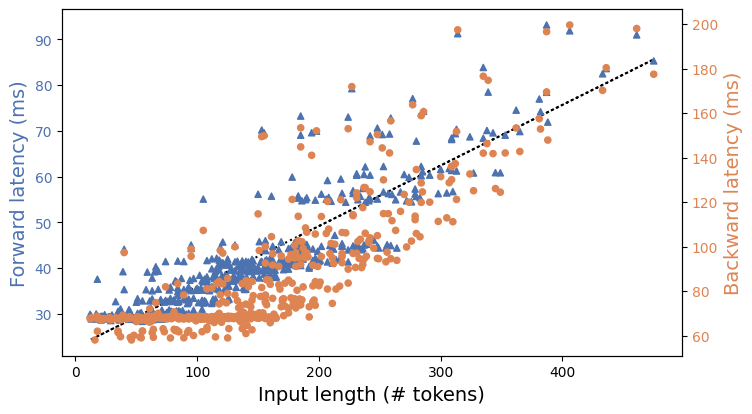

(array([ 0.13250574, 22.69707764]), 37.63069517345088)

In [14]:
fit_trend(task_stats_df.loc[(task_stats_df['forward_time'] <= 100) & (task_stats_df['backward_time'] <= 200)], X='input_length', Y='forward_time',
          out_file='figure/length_latency_dialogpt-large.pdf')

In [ ]:
# # Load stages from disk
# new_stages = get_stages(
#     config=config,
#     token=None,
#     model_name_or_path="microsoft/DialoGPT-small",
#     num_stages=4,
#     init_device=4,
#     timing_info=defaultdict(list),
# )
# # Adjust stage device
# for i in range(len(new_stages)):
#     new_stages[i].load_state_dict(torch.load(f"stage_{i}.pt"))

# # Log each stage's device   
# for i in range(len(new_stages)):
#     print(f"Stage {i} device: {new_stages[i]._device}")

# outputs = stages_decoding(new_stages, inputs)
# loss = outputs[0]
# print('decoding loss: ', loss)
# start_stage = new_stages[0]
# print(start_stage.h[-1].attn.c_attn.weight)

In [11]:
import sys 
sys.dont_write_bytecode = True
import torch
from tqdm import tqdm
import pandas as pd
from models import _prepare_decoding_inputs, _prepare_inputs
from transformers import AdamW, get_scheduler

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, config=config).to(0)

optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=100,
)

losses = []
task_stats = []

# Let's use 100 steps for demonstration
pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
for step, inputs in pbar:
    instance = {}
    instance['taskID'] = step
    instance['input_length'] = inputs['input_ids'].shape[1]
    new_inputs = _prepare_decoding_inputs(inputs)
    new_inputs = _prepare_inputs(new_inputs, device=0)
    # Forward pass for CLM
    forward_start = torch.cuda.Event(enable_timing=True)
    forward_end = torch.cuda.Event(enable_timing=True)
    forward_start.record()
    outputs = model(**new_inputs)
    forward_end.record()
    torch.cuda.synchronize()
    instance['forward_time'] = forward_start.elapsed_time(forward_end)
    loss = outputs.loss
    pbar.set_description(f"loss: {loss.item()}")
    
    backward_start = torch.cuda.Event(enable_timing=True)
    backward_end = torch.cuda.Event(enable_timing=True)
    backward_start.record()
    loss.backward()
    backward_end.record()
    torch.cuda.synchronize()
    instance['backward_time'] = backward_start.elapsed_time(backward_end)
    
    # Update optimizer and scheduler
    optimizer.step()

    # Update learning rate
    scheduler.step()

    # Clear gradients
    optimizer.zero_grad()
    
    task_stats.append(instance)
    
task_stats_df = pd.DataFrame(task_stats)

/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
loss: 2.486022710800171: 100%|██████████| 500/500 [00:23<00:00, 21.24it/s] 


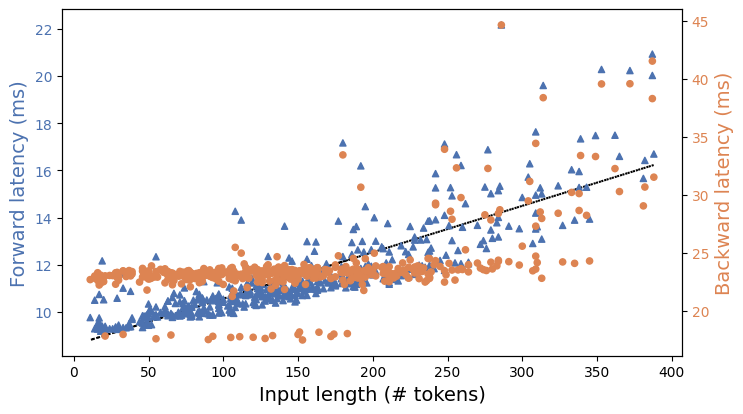

(array([0.01969171, 8.58833061]), 1.1597528622628985)

In [12]:
fit_trend(task_stats_df[task_stats_df['input_length'] <= 400], X='input_length', Y='forward_time')

## Analysis

### Section 2.2

In [44]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

LABEL2METHOD = {
    "NaiveMix": "active",
    "Separate": "isolated",
    "LaMix-LLF": "interval",
    "LaMix-MLF": "interval-MLF",
}
LABEL2LINESTYLE = {
    "NaiveMix": "-",
    "Separate": "dotted",
    "LaMix-LLF": (0, (1, 10)),
    "LaMix-MLF": '-',
}


def plot_dual(lambda_=50, label1='Separate', label2='NaiveMix', label3=None, label4=None, label5=None, 
              legend=True, legend_fontsize=14, figname=None, isolated_split=None, priority='FIFO', 
              load_balancing='random', num_nodes=2, model='DialoGPT-small', idles='idles', length_distribution='random',
              color1=sns.color_palette("deep")[0], 
              color2=sns.color_palette("deep")[1],):
    
    res1, res2, res3, res4, res5 = [], [], [], [], []
    res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
    for retrain_rate in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,]:
        if isolated_split is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}-split{isolated_split}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res1.append(metric)
        else:
            if num_nodes > 2:
                for split in [0, 0.5, -1.0]:
                    metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}-split{split}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
                    metric["retrain_rate"] = retrain_rate
                    metric["isolated_split"] = split
                    res1.append(metric)
            else:
                metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}_poisson_{retrain_rate}.json"))
                metric["retrain_rate"] = retrain_rate
                res1.append(metric)
        metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label2]}_poisson_{retrain_rate}.json"))
        metric["retrain_rate"] = retrain_rate
        res2.append(metric)
        if label3 is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label3]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res3.append(metric)
        if label4 is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label4]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res4.append(metric)
        if label5 is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label5]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res5.append(metric)
    
    res1 = pd.DataFrame(res1)
    res2 = pd.DataFrame(res2)
    res3 = pd.DataFrame(res3) if res3 else None
    res4 = pd.DataFrame(res4) if res4 else None
    res5 = pd.DataFrame(res5) if res5 else None

    # Let's plot the metrics, x-axis is retrain_rate, y-axis is the metric value
    os.makedirs("figure", exist_ok=True) 
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
    lines = []
    ax2 = axes[0].twinx()
    # ax.yaxis.grid(True, linestyle='dotted', which='major', color='grey', alpha=0.5)
    if isolated_split is None and num_nodes > 2:
        for j, (split, split_name) in enumerate([(0, '3-1'), (0.5, '2-2'), (-1.0, '1-3')]):
            res = res1[res1["isolated_split"] == split]
            line1, = axes[0].plot(res["retrain_rate"], res["loss"], label=f"{label1}-{split_name}", color=sns.color_palette("Blues")[1], marker='v', linestyle=LABEL2LINESTYLE[label1])
            line2, = ax2.plot(res["retrain_rate"], res["user_response"] * 1000, label=f"{label1}-{split_name}", color=sns.color_palette("Oranges")[1], marker='x', linestyle=LABEL2LINESTYLE[label1])
            lines += [line1, line2]
        # Get the minimum user_response across the three splits under each retrain_rate
        min_loss = res1.groupby("retrain_rate")["loss"].min()
        line3, = axes[0].plot(res['retrain_rate'].unique(), min_loss, label=f"{label1}-best", color=color1, marker='v', linestyle=LABEL2LINESTYLE[label1])
        min_user_response = res1.groupby("retrain_rate")["user_response"].min()
        line4, = ax2.plot(res['retrain_rate'].unique(), min_user_response * 1000, label=f"{label1}-best", color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line3, line4]
    else:
        line1, = axes[0].plot(res1["retrain_rate"], res1["loss"], label=label1, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label1])
        line2, = ax2.plot(res1["retrain_rate"], res1["user_response"] * 1000, label=label1, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line1, line2]
    line1_1, = axes[0].plot(res2["retrain_rate"], res2["loss"], label=label2, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label2])
    line2_2, = ax2.plot(res2["retrain_rate"], res2["user_response"] * 1000, label=label2, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label2])
    lines += [line1_1, line2_2]
    if res3 is not None:
        line1_2, = axes[0].plot(res3["retrain_rate"], res3["loss"], label=label3, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label3])
        line2_3, = ax2.plot(res3["retrain_rate"], res3["user_response"] * 1000, label=label3, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label3])
        lines += [line1_2, line2_3]
    if res4 is not None:
        line1_3, = axes[0].plot(res4["retrain_rate"], res4["loss"], label=label4, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label4])
        line2_4, = ax2.plot(res4["retrain_rate"], res4["user_response"] * 1000, label=label4, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label4])
        lines += [line1_3, line2_4]
    if res5 is not None:
        line1_4, = axes[0].plot(res5["retrain_rate"], res5["loss"], label=label5, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label5])
        line2_5, = ax2.plot(res5["retrain_rate"], res5["user_response"] * 1000, label=label5, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label5])
        lines += [line1_4, line2_5]
    
    ax2.set_ylabel("Response time (ms)", fontsize=15, color=color2)
    ax2.tick_params(axis='y', colors=color2)
    labels = [line.get_label() for line in lines]
    axes[0].set_ylabel("Eval loss", fontsize=15, color=color1)
    axes[0].tick_params(axis='y', colors=color1)
    axes[0].set_xlabel("Retraining rate", fontsize=14)
    lines = []
    ax2 = axes[1].twinx()
    if isolated_split is None and num_nodes > 2:
        for j, (split, split_name) in enumerate([(0, '3-1'), (0.5, '2-2'), (-1.0, '1-3')]):
            res = res1[res1["isolated_split"] == split]
            line1, = axes[1].plot(res["retrain_rate"], res[idles], label=f"{label1}-{split_name}", color=sns.color_palette("Blues")[1], marker='v', linestyle=LABEL2LINESTYLE[label1])
            line2, = ax2.plot(res["retrain_rate"], res["end2end_latency"], label=f"{label1}-{split_name}", color=sns.color_palette("Oranges")[1], marker='x', linestyle=LABEL2LINESTYLE[label1])
            lines += [line1, line2]
        # Get the minimum user_response across the three splits under each retrain_rate
        min_idles = res1.groupby("retrain_rate")[idles].min()
        line3, = axes[1].plot(res['retrain_rate'].unique(), min_idles, label=f"{label1}-best", color=color1, marker='v', linestyle=LABEL2LINESTYLE[label1])
        min_e2e_latency = res1.groupby("retrain_rate")["end2end_latency"].min()
        line4, = ax2.plot(res['retrain_rate'].unique(), min_e2e_latency, label=f"{label1}-best", color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line3, line4]
    else:   
        line1, = axes[1].plot(res1["retrain_rate"], res1[idles], label=label1, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label1])
        line2, = ax2.plot(res1["retrain_rate"], res1["end2end_latency"], label=label1, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line1, line2]
    line1_1, = axes[1].plot(res2["retrain_rate"], res2[idles], label=label2, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label2])
    line2_2, = ax2.plot(res2["retrain_rate"], res2["end2end_latency"], label=label2, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label2])
    lines += [line1_1, line2_2]
    if res3 is not None:
        line1_2, = axes[1].plot(res3["retrain_rate"], res3[idles], label=label3, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label3])
        line2_3, = ax2.plot(res3["retrain_rate"], res3["end2end_latency"], label=label3, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label3])
        lines += [line1_2, line2_3]
    if res4 is not None:
        line1_3, = axes[1].plot(res4["retrain_rate"], res4[idles], label=label4, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label4])
        line2_4, = ax2.plot(res4["retrain_rate"], res4["end2end_latency"], label=label4, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label4])
        lines += [line1_3, line2_4]
    if res5 is not None:
        line1_4, = axes[1].plot(res5["retrain_rate"], res5[idles], label=label5, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label5])
        line2_5, = ax2.plot(res5["retrain_rate"], res5["end2end_latency"], label=label5, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label5])
        lines += [line1_4, line2_5]
        
    ax2.set_ylabel("End2end latency (s)", fontsize=15, color=color2)
    ax2.tick_params(axis='y', colors=color2)
    labels = [line.get_label() for line in lines]
    # Create a single legend for both lines together
    # axes[1].set_ylabel("Bubble rate (%)", fontsize=15, color=color1)
    axes[1].set_ylabel("GPU idles (s)", fontsize=15, color=color1)
    axes[1].tick_params(axis='y', colors=color1)
    axes[1].set_xlabel("Retraining rate", fontsize=14)
    if legend:
        ncol = len(labels) // 2
        # if res2 is not None: ncol += 1
        # if res3 is not None: ncol += 1
        # if res4 is not None: ncol += 1
        # if res5 is not None: ncol += 1
        fig.legend(lines, labels, loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.2), fontsize=legend_fontsize)
    plt.tight_layout()
    if figname:
        plt.savefig(f"figure/{figname}.pdf", bbox_inches='tight')
    else:
        plt.savefig(f"figure/dialogpt_retraining_lambda={lambda_}_node={num_nodes}.pdf", bbox_inches='tight')
    plt.show()

#### 2-node

In [ ]:
# plot_dual(lambda_=5, figname="dialogpt-small_sep_mix_lambda=5", model='DialoGPT-small', legend=True, num_nodes=2)
plot_dual(lambda_=10, figname="dialogpt-small_sep_mix_lambda=10", model='DialoGPT-small', legend=True, num_nodes=2)
# plot_dual(lambda_=20, figname="dialogpt-small_sep_mix_lambda=20", model='DialoGPT-small', legend=False, num_nodes=2)
plot_dual(lambda_=30, figname="dialogpt-small_sep_mix_lambda=30", model='DialoGPT-small', legend=False, num_nodes=2)
plot_dual(lambda_=50, figname="dialogpt-small_sep_mix_lambda=50", model='DialoGPT-small', legend=False, num_nodes=2)

In [ ]:
# plot_dual(lambda_=5, figname="dialogpt-medium_sep_mix_lambda=5", model='DialoGPT-medium', legend=True, num_nodes=2,)
plot_dual(lambda_=10, figname="dialogpt-medium_sep_mix_lambda=10", model='DialoGPT-medium', legend=True, num_nodes=2,)
# plot_dual(lambda_=15, figname="dialogpt-medium_sep_mix_lambda=15", model='DialoGPT-medium', legend=False, num_nodes=2,)
# plot_dual(lambda_=20, figname="dialogpt-medium_sep_mix_lambda=20", model='DialoGPT-medium', legend=False, num_nodes=2,)
# plot_dual(lambda_=25, figname="dialogpt-medium_sep_mix_lambda=25", model='DialoGPT-medium', legend=False, num_nodes=2,)
plot_dual(lambda_=30, figname="dialogpt-medium_sep_mix_lambda=30", model='DialoGPT-medium', legend=False, num_nodes=2)
plot_dual(lambda_=50, figname="dialogpt-medium_sep_mix_lambda=50", model='DialoGPT-medium', legend=False, num_nodes=2)

In [ ]:
plot_dual(lambda_=10, figname="dialogpt-large_sep_mix_lambda=10_node=2", model='DialoGPT-large', legend=True, num_nodes=2)
plot_dual(lambda_=30, figname="dialogpt-large_sep_mix_lambda=30_node=2", model='DialoGPT-large', legend=False, num_nodes=2)
plot_dual(lambda_=50, figname="dialogpt-large_sep_mix_lambda=50_node=2", model='DialoGPT-large', legend=False, num_nodes=2)

#### 4-node

In [ ]:
plot_dual(lambda_=10, figname="dialogpt-large_sep_mix_lambda=10_node=4", model='DialoGPT-large', legend=True, num_nodes=4)
plot_dual(lambda_=30, figname="dialogpt-large_sep_mix_lambda=30_node=4", model='DialoGPT-large', legend=False, num_nodes=4)
plot_dual(lambda_=50, figname="dialogpt-large_sep_mix_lambda=50_node=4", model='DialoGPT-large', legend=False, num_nodes=4)

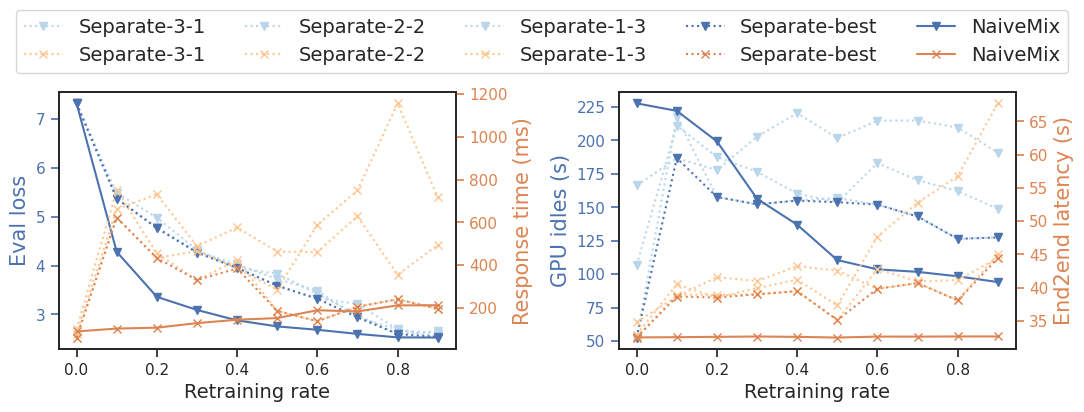

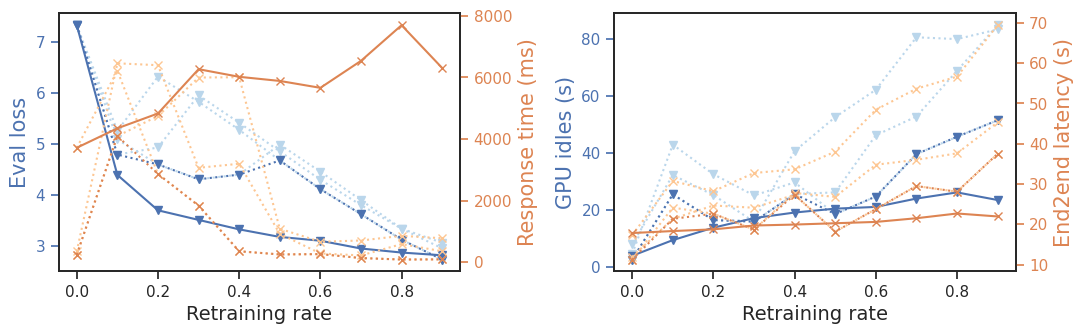

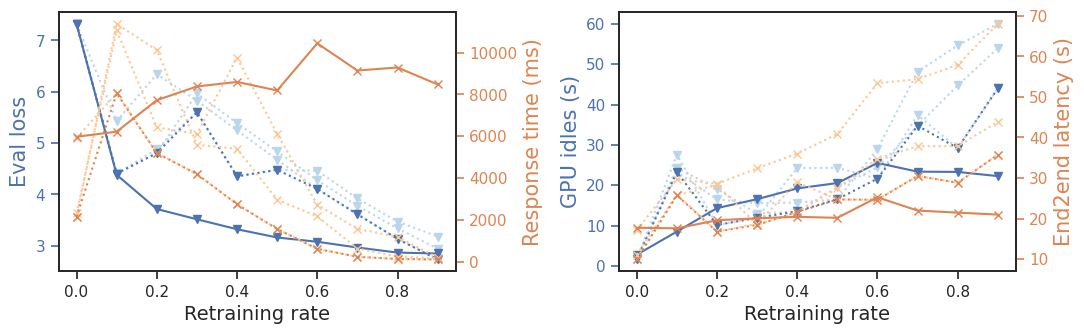

In [45]:
plot_dual(lambda_=10, figname="dialogpt-large_sep-all_mix_lambda=10_node=4", model='DialoGPT-large', legend=True, num_nodes=4)
# plot_dual(lambda_=20, figname="dialogpt-large_sep-all_mix_lambda=20_node=4", model='DialoGPT-large', legend=False, num_nodes=4)
plot_dual(lambda_=30, figname="dialogpt-large_sep-all_mix_lambda=30_node=4", model='DialoGPT-large', legend=False, num_nodes=4)
plot_dual(lambda_=50, figname="dialogpt-large_sep-all_mix_lambda=50_node=4", model='DialoGPT-large', legend=False, num_nodes=4)

## Improvement over NaiveMix

In [ ]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=10_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=30_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=50_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=10_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=30_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=50_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

### Load balancing

In [ ]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=10_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=30_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-LLF", label3="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=50_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=10_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=30_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-LLF", label3="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=50_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-BalanceNode', figname="dialogpt-large_workload_retraining_lambda=10_node=2", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=2, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-BalanceNode', figname="dialogpt-large_workload_retraining_lambda=30_node=2", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=2, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-BalanceNode', figname="dialogpt-large_workload_retraining_lambda=50_node=2", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=2, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

## 4-Node

In [ ]:
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-small_retraining_lambda=10_node=4", model='dialogpt-small',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-small_retraining_lambda=30_node=4", model='dialogpt-small',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-small_retraining_lambda=50_node=4", model='dialogpt-small',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-medium_retraining_lambda=10_node=4", model='dialogpt-medium',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-medium_retraining_lambda=30_node=4", model='dialogpt-medium',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-medium_retraining_lambda=50_node=4", model='dialogpt-medium',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-large_retraining_lambda=10_node=4", model='dialogpt-large',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-large_retraining_lambda=30_node=4", model='dialogpt-large',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-large_retraining_lambda=50_node=4", model='dialogpt-large',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

### Load balancing

In [ ]:
import sys 
sys.dont_write_bytecode = True
import seaborn as sns
from utils import plot_dual, plot_single

load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-small_workload_retraining_lambda=10_node=4", model='dialogpt-small', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-small_workload_retraining_lambda=30_node=4", model='dialogpt-small', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-small_workload_retraining_lambda=50_node=4", model='dialogpt-small', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-medium_workload_retraining_lambda=10_node=4", model='dialogpt-medium', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-medium_workload_retraining_lambda=30_node=4", model='dialogpt-medium', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-medium_workload_retraining_lambda=50_node=4", model='dialogpt-medium', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-large_workload_retraining_lambda=10_node=4", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-large_workload_retraining_lambda=30_node=4", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-large_workload_retraining_lambda=50_node=4", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [ ]:
import random
random.expovariate(10)

In [17]:
# a = {1: 10, 2: 5, 0: 1}
# return key with max value that doesn't equal to 1
# max(a, key=a.get)
# max(a, key=lambda x: a[x] if x != 1 else 0)
# return max value whose key is not 1
a = {1: 4, 0: 3, 2: 11}
# min(a.values(), key=lambda x: x if x != 0 else 0)
# return the minimum value whose corresponding key is not 0
# min(a.values(), key=lambda x: x if x != 0 else float('inf'))
min(a, key=lambda x: a[x] if x != 0 else float('inf'))
# the above code is not correct, rewrite it
# min(v for k, v in a.items() if k != 0)

1

In [13]:
a = list(range(20))
# Split sentences into two halves
mid_index = len(a) // 2
short_sentences = a[:mid_index]
long_sentences = a[mid_index:]
# Rearrange sentences in groups of bptt
sentences = []
bptt = 1
for i in range(0, max(len(short_sentences), len(long_sentences)), bptt):
    sentences.extend(short_sentences[i:i+bptt])
    sentences.extend(long_sentences[i:i+bptt])
print(sentences)

[0, 10, 1, 11, 2, 12, 3, 13, 4, 14, 5, 15, 6, 16, 7, 17, 8, 18, 9, 19]


### Different length arrival patterns

In [83]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

LABEL2METHOD = {
    "NaiveMix": "active",
    "Separate": "isolated",
    "LaMix-LLF": "interval",
    "LaMix-MLF": "interval-MLF",
}
LABEL2LINESTYLE = {
    "NaiveMix": "dashed",
    "Separate": "dotted",
    "LaMix-LLF": (0, (1, 10)),
    "LaMix-MLF": '-',
}

def plot_single(
    lambda_=50, label1='Separate', label2='NaiveMix', isolated_split=0,
    pattern1='random', pattern2='ascending', pattern3='descending', pattern4='bursty', 
    legend=True, legend_fontsize=14, figname=None, load_balancing='random', priority='FIFO',
    workload='poisson', num_nodes=2, model='DialoGPT-small', idles='bubble_rate',
    color1=sns.color_palette("deep")[0], color2=sns.color_palette("deep")[1],
):
    # Let's plot the metrics, x-axis is retrain_rate, y-axis is the metric value
    os.makedirs("figure", exist_ok=True) 
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
    for i, lambda_ in enumerate([10, 20, 30, 50]):
        ax = axes[i]
        res1, res2 = [], []
        res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
        for length_distribution in [pattern1, pattern2, pattern3, pattern4]:
            for retrain_rate in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,]:
                metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_isolated-split{isolated_split}-{priority}_{workload}-{length_distribution}_{retrain_rate}.json"))
                metric["retrain_rate"] = retrain_rate
                metric["length_distribution"] = length_distribution
                res1.append(metric)
                metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_active-{priority}_{workload}-{length_distribution}_{retrain_rate}.json"))
                metric["retrain_rate"] = retrain_rate
                metric["length_distribution"] = length_distribution
                res2.append(metric)
                
        res1 = pd.DataFrame(res1)
        res2 = pd.DataFrame(res2)
        
        lines = []
        # ax.yaxis.grid(True, linestyle='dotted', which='major', color='grey', alpha=0.5)
        for j, length_distribution in enumerate([pattern1, pattern2, pattern3, pattern4]):
            res1_ = res1[res1["length_distribution"] == length_distribution]
            res1_loss0 = res1_[res1_["retrain_rate"] == 0.0]["loss"].values[0]
            res2_ = res2[res2["length_distribution"] == length_distribution]
            res2_loss0 = res2_[res2_["retrain_rate"] == 0.0]["loss"].values[0]
            # ax = axes[i]
            # ax2 = ax.twinx()
            line1, = ax.plot(res1_["retrain_rate"], (res1_loss0 - res1_['loss']) / res1_["end2end_latency"], label=f'{label1}-{length_distribution}', color=sns.color_palette("Blues")[-j-1], marker='v', linestyle=LABEL2LINESTYLE[label1])
            # line2, = ax2.plot(res1_["retrain_rate"], res1_["end2end_latency"], label=label1, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
            line1_2, = ax.plot(res2_["retrain_rate"], (res2_loss0 - res2_['loss']) / res2_["end2end_latency"], label=f'{label2}-{length_distribution}', color=sns.color_palette("Oranges")[-j-1], marker='x', linestyle=LABEL2LINESTYLE[label2])
            # line2_2, = ax2.plot(res2_["retrain_rate"], res2_["end2end_latency"], label=label2, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label2])
            # ax.set_title(length_distribution, fontsize=15)
            ax.set_xlabel("Retraining rate", fontsize=14)
            ax.set_ylabel("Loss reduction (/s)", fontsize=15, color=color1)
            # ax2.set_ylabel("E2E latency (s)", fontsize=15, color=color2)
            # ax.legend(fontsize=10)
            lines += [line1, line1_2]
    
    labels = [line.get_label() for line in lines]
    if legend:
        ncol = len(lines) // 2
        fig.legend(lines, labels, loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.2), fontsize=legend_fontsize)
    plt.tight_layout()
    if figname:
        plt.savefig(f"figure/{figname}.pdf", bbox_inches='tight')
    else:
        plt.savefig(f"figure/dialogpt_length-study_lambda={lambda_}_node={num_nodes}.pdf", bbox_inches='tight')
    plt.show()

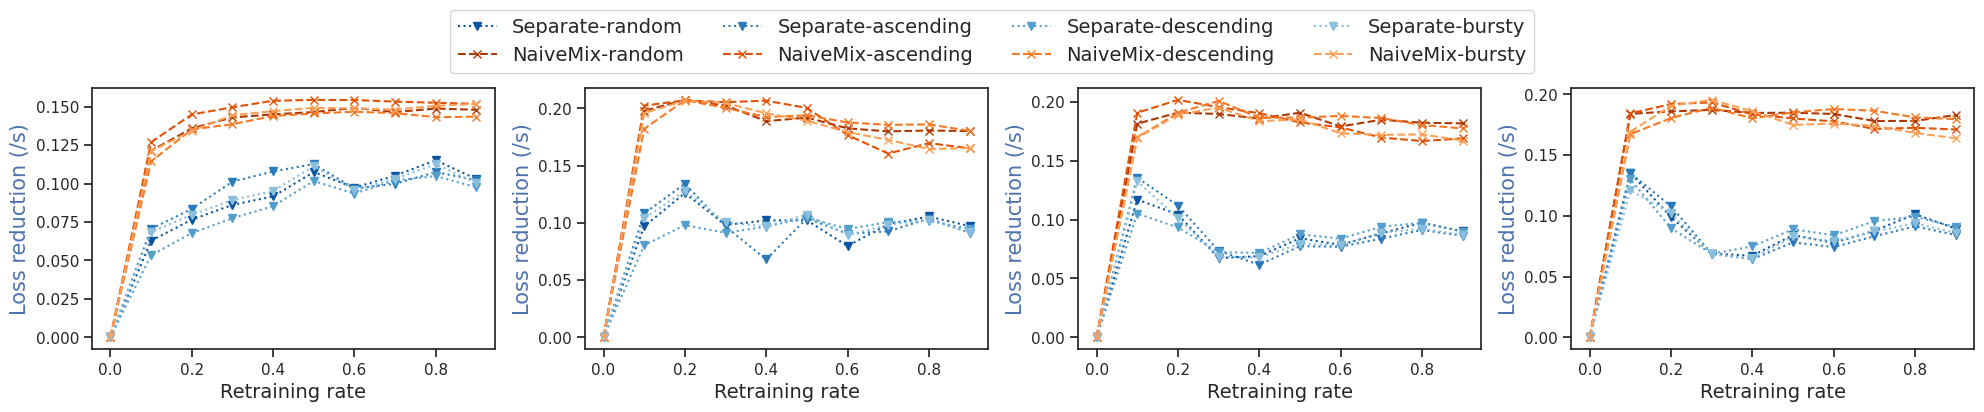

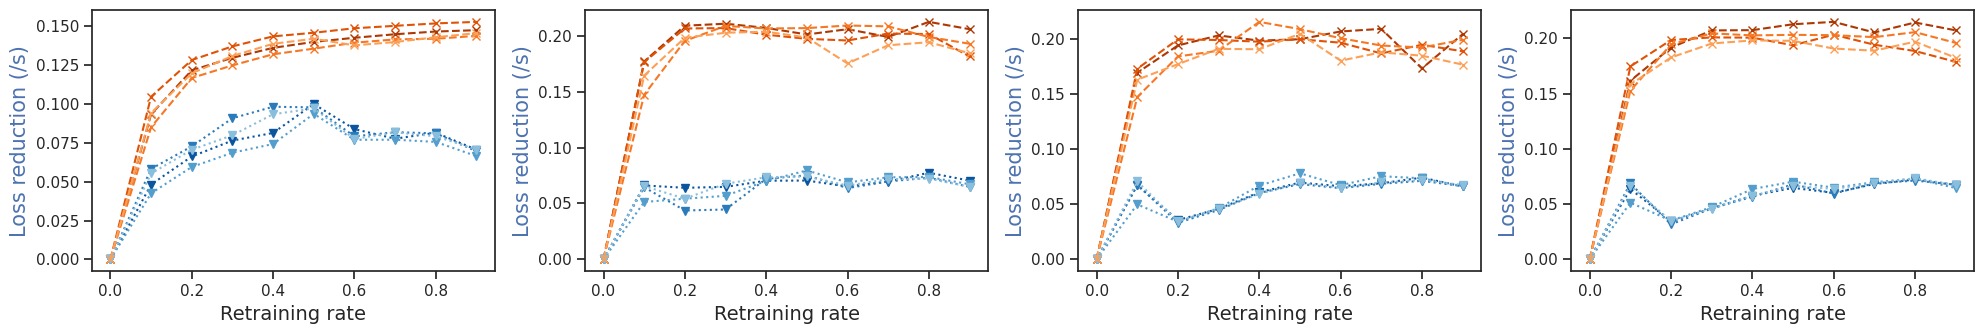

In [87]:
plot_single(model='DialoGPT-large', figname="dialogpt-large_length-study_lambda=10-20-30-50_node=2", num_nodes=2)
plot_single(model='DialoGPT-large', figname="dialogpt-large_length-study_lambda=10-20-30-50_node=4", num_nodes=4, legend=False)
# plot_single(lambda_=30, model='DialoGPT-large', figname="dialogpt-large_length-study_lambda=30_node=2", num_nodes=2, legend=False)

### Varying lambda

In [5]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

LABEL2METHOD = {
    "NaiveMix": "active",
    "Separate": "isolated",
    "LaMix-LLF": "interval",
    "LaMix-MLF": "interval-MLF",
}
LABEL2LINESTYLE = {
    "NaiveMix": "-",
    "Separate": "dotted",
    "LaMix-LLF": (0, (1, 10)),
    "LaMix-MLF": '-',
}


def plot_dual(label1='Separate', label2='NaiveMix', label3=None, label4=None, label5=None, 
              legend=True, legend_fontsize=14, figname=None, isolated_split=None, priority='FIFO', 
              load_balancing='random', num_nodes=2, model='DialoGPT-small', idles='idles', length_distribution='random',
              color1=sns.color_palette("deep")[0], 
              color2=sns.color_palette("deep")[1],):
    
    res1, res2, res3, res4, res5 = [], [], [], [], []
    res_dir = f"prof/{num_nodes}_node/varying_lambda"
    for retrain_rate in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,]:
        if isolated_split is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}-split{isolated_split}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res1.append(metric)
        else:
            if num_nodes > 2:
                for split in [0.0, 0.5, -1.0]:
                    metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}-split{split}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
                    metric["retrain_rate"] = retrain_rate
                    metric["isolated_split"] = split
                    res1.append(metric)
            else:
                metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}_poisson_{retrain_rate}.json"))
                metric["retrain_rate"] = retrain_rate
                res1.append(metric)
        metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label2]}-{priority}_poisson_{retrain_rate}.json"))
        metric["retrain_rate"] = retrain_rate
        res2.append(metric)
        if label3 is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label3]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res3.append(metric)
        if label4 is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label4]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res4.append(metric)
        if label5 is not None:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label5]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res5.append(metric)
    
    res1 = pd.DataFrame(res1)
    res2 = pd.DataFrame(res2)
    res3 = pd.DataFrame(res3) if res3 else None
    res4 = pd.DataFrame(res4) if res4 else None
    res5 = pd.DataFrame(res5) if res5 else None

    # Let's plot the metrics, x-axis is retrain_rate, y-axis is the metric value
    os.makedirs("figure", exist_ok=True) 
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
    lines = []
    ax2 = axes[0].twinx()
    # ax.yaxis.grid(True, linestyle='dotted', which='major', color='grey', alpha=0.5)
    if isolated_split is None and num_nodes > 2:
        for j, (split, split_name) in enumerate([(0, '3-1'), (0.5, '2-2'), (-1.0, '1-3')]):
            res = res1[res1["isolated_split"] == split]
            line1, = axes[0].plot(res["retrain_rate"], res["loss"], label=f"{label1}-{split_name}", color=sns.color_palette("Blues")[1], marker='v', linestyle=LABEL2LINESTYLE[label1])
            line2, = ax2.plot(res["retrain_rate"], res["user_response"] * 1000, label=f"{label1}-{split_name}", color=sns.color_palette("Oranges")[1], marker='x', linestyle=LABEL2LINESTYLE[label1])
            lines += [line1, line2]
        # Get the minimum user_response across the three splits under each retrain_rate
        min_loss = res1.groupby("retrain_rate")["loss"].min()
        line3, = axes[0].plot(res['retrain_rate'].unique(), min_loss, label=f"{label1}-best", color=color1, marker='v', linestyle=LABEL2LINESTYLE[label1])
        min_user_response = res1.groupby("retrain_rate")["user_response"].min()
        line4, = ax2.plot(res['retrain_rate'].unique(), min_user_response * 1000, label=f"{label1}-best", color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line3, line4]
    else:
        line1, = axes[0].plot(res1["retrain_rate"], res1["loss"], label=label1, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label1])
        line2, = ax2.plot(res1["retrain_rate"], res1["user_response"] * 1000, label=label1, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line1, line2]
    line1_1, = axes[0].plot(res2["retrain_rate"], res2["loss"], label=label2, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label2])
    line2_2, = ax2.plot(res2["retrain_rate"], res2["user_response"] * 1000, label=label2, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label2])
    lines += [line1_1, line2_2]
    if res3 is not None:
        line1_2, = axes[0].plot(res3["retrain_rate"], res3["loss"], label=label3, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label3])
        line2_3, = ax2.plot(res3["retrain_rate"], res3["user_response"] * 1000, label=label3, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label3])
        lines += [line1_2, line2_3]
    if res4 is not None:
        line1_3, = axes[0].plot(res4["retrain_rate"], res4["loss"], label=label4, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label4])
        line2_4, = ax2.plot(res4["retrain_rate"], res4["user_response"] * 1000, label=label4, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label4])
        lines += [line1_3, line2_4]
    if res5 is not None:
        line1_4, = axes[0].plot(res5["retrain_rate"], res5["loss"], label=label5, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label5])
        line2_5, = ax2.plot(res5["retrain_rate"], res5["user_response"] * 1000, label=label5, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label5])
        lines += [line1_4, line2_5]
    
    ax2.set_ylabel("Response time (ms)", fontsize=15, color=color2)
    ax2.tick_params(axis='y', colors=color2)
    labels = [line.get_label() for line in lines]
    axes[0].set_ylabel("Eval loss", fontsize=15, color=color1)
    axes[0].tick_params(axis='y', colors=color1)
    axes[0].set_xlabel("Retraining rate", fontsize=14)
    lines = []
    ax2 = axes[1].twinx()
    if isolated_split is None and num_nodes > 2:
        for j, (split, split_name) in enumerate([(0, '3-1'), (0.5, '2-2'), (-1.0, '1-3')]):
            res = res1[res1["isolated_split"] == split]
            line1, = axes[1].plot(res["retrain_rate"], res[idles], label=f"{label1}-{split_name}", color=sns.color_palette("Blues")[1], marker='v', linestyle=LABEL2LINESTYLE[label1])
            line2, = ax2.plot(res["retrain_rate"], res["end2end_latency"], label=f"{label1}-{split_name}", color=sns.color_palette("Oranges")[1], marker='x', linestyle=LABEL2LINESTYLE[label1])
            lines += [line1, line2]
        # Get the minimum user_response across the three splits under each retrain_rate
        min_idles = res1.groupby("retrain_rate")[idles].min()
        line3, = axes[1].plot(res['retrain_rate'].unique(), min_idles, label=f"{label1}-best", color=color1, marker='v', linestyle=LABEL2LINESTYLE[label1])
        min_e2e_latency = res1.groupby("retrain_rate")["end2end_latency"].min()
        line4, = ax2.plot(res['retrain_rate'].unique(), min_e2e_latency, label=f"{label1}-best", color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line3, line4]
    else:   
        line1, = axes[1].plot(res1["retrain_rate"], res1[idles], label=label1, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label1])
        line2, = ax2.plot(res1["retrain_rate"], res1["end2end_latency"], label=label1, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
        lines += [line1, line2]
    line1_1, = axes[1].plot(res2["retrain_rate"], res2[idles], label=label2, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label2])
    line2_2, = ax2.plot(res2["retrain_rate"], res2["end2end_latency"], label=label2, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label2])
    lines += [line1_1, line2_2]
    if res3 is not None:
        line1_2, = axes[1].plot(res3["retrain_rate"], res3[idles], label=label3, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label3])
        line2_3, = ax2.plot(res3["retrain_rate"], res3["end2end_latency"], label=label3, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label3])
        lines += [line1_2, line2_3]
    if res4 is not None:
        line1_3, = axes[1].plot(res4["retrain_rate"], res4[idles], label=label4, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label4])
        line2_4, = ax2.plot(res4["retrain_rate"], res4["end2end_latency"], label=label4, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label4])
        lines += [line1_3, line2_4]
    if res5 is not None:
        line1_4, = axes[1].plot(res5["retrain_rate"], res5[idles], label=label5, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label5])
        line2_5, = ax2.plot(res5["retrain_rate"], res5["end2end_latency"], label=label5, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label5])
        lines += [line1_4, line2_5]
        
    ax2.set_ylabel("End2end latency (s)", fontsize=15, color=color2)
    ax2.tick_params(axis='y', colors=color2)
    labels = [line.get_label() for line in lines]
    # Create a single legend for both lines together
    # axes[1].set_ylabel("Bubble rate (%)", fontsize=15, color=color1)
    axes[1].set_ylabel("GPU idles (s)", fontsize=15, color=color1)
    axes[1].tick_params(axis='y', colors=color1)
    axes[1].set_xlabel("Retraining rate", fontsize=14)
    if legend:
        ncol = len(labels) // 2
        # if res2 is not None: ncol += 1
        # if res3 is not None: ncol += 1
        # if res4 is not None: ncol += 1
        # if res5 is not None: ncol += 1
        fig.legend(lines, labels, loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.2), fontsize=legend_fontsize)
    plt.tight_layout()
    if figname:
        plt.savefig(f"figure/{figname}.pdf", bbox_inches='tight')
    else:
        plt.savefig(f"figure/dialogpt_retraining_lambda={lambda_}_node={num_nodes}.pdf", bbox_inches='tight')
    plt.show()

In [6]:
plot_dual(figname="dialogpt-large_sep-all_mix_varying-lambda_node=4", model='DialoGPT-large', legend=True, num_nodes=4)

FileNotFoundError: [Errno 2] No such file or directory: 'prof/4_node/varying_lambda/DialoGPT-large/metrics_DialoGPT-large_random_active-FIFO_poisson_0.0.json'